# Inicialización del Entorno

## Parámetros Globales

In [4]:
from math import sqrt, pi, erf

MAX_UINT32 = 0xFFFFFFFF
MAX_UINT64 = 0xFFFFFFFFFFFFFFFF
sqrtPi = sqrt(pi)
erf1 = erf(1)
dimensiones = [2, 5, 10]
tamaños = [10**4, 10**5, 10**6]
valores_reales = {d: ((sqrtPi * erf1) / 2) ** d for d in dimensiones}
CGL_ORIGIN_STATE = 4155788116
XOR32_ORIGIN_STATE = 3016030231
XOR64_ORIGIN_STATE = 17816317102425885533
XOR128_ORIGIN_STATE = [8551759191851867145, 9037421324366481566]
XOSHIRO_ORIGIN_STATE = [608405726, 470204612, 4172113938, 3888846613]

# Generador Congruencial Lineal
CGL_STATE = CGL_ORIGIN_STATE
a = 16807
M = 2**31 - 1

# Xorshift (32,64,128)
XOR32_STATE = XOR32_ORIGIN_STATE
a_xorshift32 = 13
b_xorshift32 = 17
c_xorshift32 = 15
XOR64_STATE = XOR64_ORIGIN_STATE
a_xorshift64 = 1
b_xorshift64 = 13
c_xorshift64 = 45
XOR128_STATE = XOR128_ORIGIN_STATE[:]
a_xorshift128 = 23
b_xorshift128 = 18
c_xorshift128 = 15

# Xoshiro128
XOSHIRO_STATE = XOSHIRO_ORIGIN_STATE[:]
a_xoshiro128 = 9
b_xoshiro128 = 11
r_xoshiro128 = 17

### Chequeos

In [5]:
from sympy import factorint

factores_primos = factorint(M-1)
es_raiz_primitiva = True

for p in factores_primos:
    if pow(a, (M-1) // p, M) == 1:
        print(f"{a} NO es raíz primitiva de {M}")
        es_raiz_primitiva = False
        break

if es_raiz_primitiva:
    print(f"a = {a} es raíz primitiva de M = {M} y por lo tanto, el periódo K = M-1 del LCG es máximo")

a = 16807 es raíz primitiva de M = 2147483647 y por lo tanto, el periódo K = M-1 del LCG es máximo


In [6]:
print("================== Semillas de los generadores ==================")

# CGL
print(f"CGL_STATE       = {CGL_STATE}")

# Xorshift32
print(f"XOR32_STATE     = {XOR32_STATE}")

# Xorshift64
print(f"XOR64_STATE     = {XOR64_STATE}")

# Xorshift128
print(f"XOR128_STATE    = {XOR128_STATE[0]}, {XOR128_STATE[1]}")

# Xoshiro128
print(f"XOSHIRO_STATE   = {XOSHIRO_STATE[0]}, {XOSHIRO_STATE[1]}, {XOSHIRO_STATE[2]}, {XOSHIRO_STATE[3]}")


================== Semillas de los generadores ==================
CGL_STATE       = 4155788116
XOR32_STATE     = 3016030231
XOR64_STATE     = 17816317102425885533
XOR128_STATE    = 8551759191851867145, 9037421324366481566
XOSHIRO_STATE   = 608405726, 470204612, 4172113938, 3888846613


## Funciones Auxiliares

In [7]:
import ctypes
import tempfile
import subprocess
import os

c_code = r"""
#include <immintrin.h>

int rdseed32(unsigned int *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed32_step(out);
        if (ok) return 1;
    }
    return 0;
}

int rdseed64(unsigned long long *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed64_step(out);
        if (ok) return 1;
    }
    return 0;
}
"""

def compile_rdseed_lib():
    with tempfile.NamedTemporaryFile(suffix=".c", delete=False) as f:
        f.write(c_code.encode())
        c_path = f.name

    so_path = c_path.replace(".c", ".so")
    compile_cmd = [
        "gcc", "-shared", "-fPIC", "-O2", "-mrdseed", "-o", so_path, c_path
    ]

    subprocess.check_call(compile_cmd)
    os.remove(c_path)
    return ctypes.CDLL(so_path)

# Cargar lib y configurar argumentos
_rdseed = compile_rdseed_lib()
_rdseed.rdseed32.argtypes = [ctypes.POINTER(ctypes.c_uint)]
_rdseed.rdseed32.restype = ctypes.c_int

_rdseed.rdseed64.argtypes = [ctypes.POINTER(ctypes.c_ulonglong)]
_rdseed.rdseed64.restype = ctypes.c_int

# Funciones públicas
def seed32():
    """
    Intenta generar un entero aleatorio no negativo de 32 bits utilizando la instrucción RDSEED.
    """
    out = ctypes.c_uint()
    if _rdseed.rdseed32(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED32 falló después de varios intentos.")
    return out.value

def seed64():
    """
    Intenta generar un entero aleatorio no negativo de 64 bits utilizando la instrucción RDSEED.
    """
    out = ctypes.c_ulonglong()
    if _rdseed.rdseed64(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED64 falló después de varios intentos.")
    return out.value


In [8]:
def rotl32(x, k):
    """
    Función auxiliar que calcula la rotación de k bits del número x y devuelve como resultado
    un número de 32 bits.
    """
    return ((x << k) | (x >> (32 - k))) & MAX_UINT32 # Máscara para que sea un numero de 32bits

In [9]:
def resetear_estados_originales():
    global CGL_STATE, XOR32_STATE, XOR64_STATE, XOR128_STATE, XOSHIRO_STATE
    
    CGL_STATE = CGL_ORIGIN_STATE
    XOR32_STATE = XOR32_ORIGIN_STATE
    XOR64_STATE = XOR64_ORIGIN_STATE
    XOR128_STATE = XOR128_ORIGIN_STATE[:]
    XOSHIRO_STATE = XOSHIRO_ORIGIN_STATE[:]

### Variables Aleatorias

In [10]:
from math import exp, factorial as fact, log, cos

#### Discretas

In [11]:
def uniforme_discreta(a, b, rng):
    """
    Simula una variable aleatoria con distribución Uniforme que toma valores en {a,b}.
    - rng: función generadora de uniformes en (0,1)
    """
    return int(b*rng()) + a

def pmf_uniforme_discreta(x, a, b):
    return 1 / (b - a + 1) if a <= x <= b else 0


In [12]:
def bernoulli(p, rng):
    """
    Simula una variable aleatoria con distribución Binomial de parámetro p.
    - rng: función generadora de uniformes en (0,1)
    """
    U = rng()
    if U < p: return 1
    else:     return 0

def pmf_bernoulli(x, p):
    return p if x == 1 else (1 - p if x == 0 else 0)


In [13]:
def binomial(n, p, rng):
    """
    Simula una variable aleatoria con distribución Binomial de parámetros n y p.
    - rng: función generadora de uniformes en (0,1)
    """
    c = p / (1 - p)
    prob = (1 - p)**n
    F = prob
    for i in range(1, int((n + 1) * p) + 1):
        prob *= (c * (n - i + 1)) / i
        F += prob
    U = rng()
    if U >= F:
        j = int((n + 1) * p) + 1
        while U >= F:
            prob *= (c * (n - j + 1)) / j
            F += prob
            j += 1
        return j - 1
    else:
        j = int((n + 1) * p)
        while U < F:
            F -= prob
            prob *= j / (c * (n - j + 1))
            j -= 1
        return j + 1
    
from math import comb

def pmf_binomial(x, n, p):
    if 0 <= x <= n:
        return comb(n, x) * p**x * (1 - p)**(n - x)
    return 0


In [14]:
def poisson(lamda, rng):
    """
    Simula una variable aleatoria con distribución de Poisson de parámetro lamda.
    - rng: función generadora de uniformes en (0,1)
    """
    p = exp(-lamda)
    F = p
    for i in range(1, int(lamda)+1): # Acumulamos hasta el valor más probable
        p *= lamda/i
        F += p
    U = rng()
    if U >= F:
        j = int(lamda)+1
        while U >= F:
            p *= lamda/j
            F += p
            j += 1
        return j-1
    else:
        j = int(lamda)
        while U < F:
            F -= p
            p *= j/lamda
            j -= 1
        return j+1

def pmf_poisson(x, lam):
    if x < 0:
        return 0
    return exp(-lam) * lam**x / fact(x)


In [15]:
def geometrica(p, rng):
    """
    Simula una variable aleatoria con distribución Geométrica de parámetro p.
    - rng: función generadora de uniformes en (0,1)
    """
    prob = p
    q = 1-p
    U = rng()
    F = prob
    i = 0
    while U >= F:
        i += 1
        prob *= q
        F += prob
    return i + 1

def pmf_geometrica(x, p):
    return (1 - p)**(x - 1) * p if x >= 1 else 0


#### Continuas

In [16]:
def uniforme(a, b, rng):
    """
    Simula una variable aleatoria con distribución uniforme en el intervalo (a,b).
    - rng: función generadora de uniformes en (0,1)
    """
    return a + (b - a) * rng()

def cdf_uniforme(x, a, b):
    if x <= a: return 0
    elif a < x < b: return (x-a)/(b-a)
    return 1

In [17]:
def normal(mu, sigma, rng):
    """
    Simula una variable aleatoria con distribución Normal de parámetros mu y sigma mediante el Método Polar.
    - rng: función generadora de uniformes en (0,1)
    """
    Rcuad = -2 * log(rng())
    Theta = 2 * pi * rng()
    Z = sqrt(Rcuad) * cos(Theta)
    return sigma*Z + mu

def cdf_normal(x, mu, sigma):
    z = (x - mu) / (sigma * sqrt(2))
    return 0.5 * (1 + erf(z))

In [18]:
def exponencial(lamda, rng):
    """
    Simula una variable aleatoria con distribución Exponencial de parámetro lamda.
    - rng: función generadora de uniformes en (0,1)
    """
    return -log(rng())/lamda

def cdf_exponencial(x, lamda):
    if x < 0:
        return 0
    return 1 - exp(-lamda * x)

In [19]:
from scipy.stats import gamma as gamma_dist

def gamma(alpha, beta, rng):
    """
    Simula una variable aleatoria con distribución Gamma de parámetros alpha (entero) y beta.
    - rng: función generadora de uniformes en (0,1)
    """
    U = 1
    for _ in range(alpha):
        U *= rng()
    return -log(U)*beta

def cdf_gamma(x, alpha, beta):
    return gamma_dist.cdf(x, a=alpha, scale=beta)


In [20]:
def weibull(alpha, beta, rng):
    """
    Simula una variable aleatoria con distribución de Weibull de parámetros alfa y beta.
    - rng: función generadora de uniformes en (0,1)
    """
    return ((-log(rng())) ** (1/alpha)) * beta

def cdf_weibull(x, alpha, beta):
    if x < 0:
        return 0
    return 1 - exp(-(x / beta)**alpha)

## Clases

### Generadores

In [21]:
class Generador:
    def __init__(self, nombre, funcion, color, Max_value, estados, parametros):
        self.nombre = nombre
        self.funcion = funcion
        self.color = color
        self.Max_value = Max_value
        self.estados = estados
        self.parametros = parametros  # Diccionario de parámetros usados

    def generar(self):
        """
        Devuelve un número pseudoaleatorio en el intervalo {1,...,K-1}.
        """
        return self.funcion()
    
    def generar_normalizado(self):
        """
        Devuelve un número pseudoaleatorio normalizado en el intervalo (0,1).
        """
        return self.generar() / self.Max_value

    


### Resultados

In [22]:
class ResultadoSimulacion:
    def __init__(self, generador, dimension, N, estimacion, tiempo, error_abs, varianza, ecm):
        self.generador = generador
        self.dimension = dimension
        self.N = N
        self.estimacion = estimacion
        self.tiempo = tiempo
        self.error_abs = error_abs
        self.varianza = varianza
        self.ecm = ecm

    def __repr__(self):
        return (f"{self.generador:12} | d={self.dimension:<2} | N={self.N:<7} | "
                f"Estimación={self.estimacion:.6f} | Error={self.error_abs:.2e} | "
                f"Varianza={self.varianza:.2e} | ECM={self.ecm:.2e} | "
                f"Tiempo={self.tiempo:.2f}s")


### Distribuciones

In [23]:
from typing import Callable, Union

class Distribucion:
    def __init__(self, nombre, parametros, tipo, generar_valor, funcion_probabilidades):
        """
        - nombre: Nombre de la distribución
        - parametros: Tupla con los parámetros (n, p), (λ,), (mu, sigma), etc.
        - tipo: 'discreta' o 'continua'
        - generar_valor: función que genera un valor aleatorio: f(*parametros, rng)
        - funcion_probabilidaes: PMF o CDF: f(x, *parametros)
        """
        assert tipo in ("discreta", "continua")
        self.nombre = nombre
        self.parametros = parametros
        self.tipo = tipo
        self.generar_valor = generar_valor
        self.funcion_probabilidades = funcion_probabilidades

    def sample(self, rng: Callable[[], float]) -> Union[int, float]:
        """
        Genera un valor aleatorio usando un generador de numeros aleatorios en el intervalo (0, 1).
        """
        return self.generar_valor(*self.parametros, rng)

    def p(self, x: Union[int, float]) -> float:
        """
        Evalúa la función de masa (discreta) o acumulada (continua) en x.
        """
        return self.funcion_probabilidades(x, *self.parametros)


# IMPLEMENTACIONES

## Generador Congruencial Lineal (LCG)

In [24]:
def LCG():
    """
    Generador Múltiplicativo de números pseudoaleatorios en el conjunto {1,...,M-1} con parámetros:
    • a = 16807
    • M = 2^31 - 1 = 2147483647
    """
    global CGL_STATE
    CGL_STATE = (a*CGL_STATE) % M 
    return CGL_STATE

## Xorshifts (32,64,128)

In [25]:
def Xorshift32():
    """
    Generador de números pseudoaleatorios en el conjunto {1,...,2^32-1} con estado de 32 bits con parámetros:
    • a = 13
    • b = 17
    • c = 5
    """
    global XOR32_STATE
    XOR32_STATE ^= XOR32_STATE << a_xorshift32 
    XOR32_STATE ^= XOR32_STATE >> b_xorshift32
    XOR32_STATE ^= XOR32_STATE << c_xorshift32
    XOR32_STATE &= MAX_UINT32 # Máscara para que sea un numero de 32bits
    return XOR32_STATE


In [26]:
def Xorshift64():
    """
    Generador de números pseudoaleatorios en el conjunto {1,...,2^64-1} con estado de 64 bits con parámetros:
    • a = 1
    • b = 13
    • c = 45
    """
    global XOR64_STATE
    XOR64_STATE ^= XOR64_STATE >> c_xorshift64
    XOR64_STATE ^= XOR64_STATE << b_xorshift64
    XOR64_STATE ^= XOR64_STATE >> a_xorshift64
    XOR64_STATE &= MAX_UINT64 # Máscara para que sea un numero de 64bits
    return XOR64_STATE

In [27]:
def Xorshift128():
    """
    Generador de números pseudoaleatorios en el conjunto {1,...,2^64-1} con 2 estados de 64 bits con parámetros:
    • a = 23
    • b = 18
    • c = 5
    """
    global XOR128_STATE
    s1 = XOR128_STATE[0]
    s0 = XOR128_STATE[1]
    result = (s0 + s1) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    XOR128_STATE[0] = s0
    s1 ^= s1 << a_xorshift128
    XOR128_STATE[1] = (s1 ^ s0 ^ (s1 >> b_xorshift128) ^ (s0 >> c_xorshift128)) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    return result

## Xoshiro128

In [28]:
def Xoshiro128():
    """
    Generador de números pseudoaleatorios pseudoaleatorios en el conjunto {1,...,2^32-1} de 32 bits con 4 estados de 32 bits con 
    parámetros:
    • a = 9
    • b = 11
    • r = 7
    """
    global XOSHIRO_STATE
    result = (rotl32(XOSHIRO_STATE[0] + XOSHIRO_STATE[3], r_xoshiro128) + XOSHIRO_STATE[0]) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    t = (XOSHIRO_STATE[1] << a_xoshiro128) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    XOSHIRO_STATE[2] ^= XOSHIRO_STATE[0]
    XOSHIRO_STATE[3] ^= XOSHIRO_STATE[1]
    XOSHIRO_STATE[1] ^= XOSHIRO_STATE[2]
    XOSHIRO_STATE[0] ^= XOSHIRO_STATE[3] 
    XOSHIRO_STATE[2] ^= t
    XOSHIRO_STATE[3] =  rotl32(XOSHIRO_STATE[3], b_xoshiro128)
    return result

# SIMULACIONES

`TODO`: RESIMULAR, RECALCULAR TABLAS Y REGRAFICAR COSTOS 

In [29]:
import numpy as np
from time import perf_counter as pc

def f(rng, d):
    prod = 1
    for _ in range(d):
        X = rng()
        prod *= exp(-1 * X**2)

    return prod

def simular(rng, d ,N):
    """
    Dado un generador de números aleatorios (rng) que devuelve valores en [0,1), estima mediante el método de Monte Carlo
    la integral sobre el hipercubo [0,1]^d usando N muestras. 
    Devuelve:
    • estimación de la integral,
    • tiempo de ejecución,
    • varianza de las estimaciones,
    • error cuadrático medio (ECM).
    """
    inicio = pc()
    Media, Scuad, n = f(rng, d), 0, 1
    for _ in range(N-1):
        n += 1
        X = f(rng, d)
        MediaAnt = Media
        Media = MediaAnt + (X - MediaAnt) / n
        Scuad = Scuad * (1 - 1/(n-1)) + n * (Media - MediaAnt)**2
    final = pc()

    ecm = Scuad + (Media - valores_reales[d])**2 # Porque la media es insesgada

    return Media, final-inicio, Scuad, ecm

In [30]:
generadores = [
    Generador("LCG", LCG, "#F68E5F", M-1, 1, {"a": a, "M": M}),
    Generador("Xorshift32", Xorshift32, "#F5DD90", MAX_UINT32, 1, {"a": a_xorshift32, "b": b_xorshift32, "c": c_xorshift32}),
    Generador("Xorshift64", Xorshift64, "#949083", MAX_UINT64, 1, {"a": a_xorshift64, "b": b_xorshift64, "c": c_xorshift64}),
    Generador("Xorshift128", Xorshift128, "#324376", MAX_UINT64, 2, {"a": a_xorshift128, "b": b_xorshift128, "c": c_xorshift128}),
    Generador("Xoshiro128", Xoshiro128, "#586BA4", MAX_UINT32, 4, {"a": a_xoshiro128, "b": b_xoshiro128, "r": r_xoshiro128}),
]

In [31]:
resultados = []

for gen in generadores:
    for d in dimensiones:
        valor_real = valores_reales[d]
        for N in tamaños:
            estimacion, tiempo, varianza, ecm = simular(gen.generar_normalizado, d, N)
            error_abs = abs(estimacion - valor_real)
            resultado = ResultadoSimulacion(gen.nombre, d, N, estimacion, tiempo, error_abs, varianza, ecm)
            resultados.append(resultado)
            print(resultado)



LCG          | d=2  | N=10000   | Estimación=0.557396 | Error=3.50e-04 | Varianza=4.68e-02 | ECM=4.68e-02 | Tiempo=0.01s
LCG          | d=2  | N=100000  | Estimación=0.557629 | Error=1.17e-04 | Varianza=4.66e-02 | ECM=4.66e-02 | Tiempo=0.09s
LCG          | d=2  | N=1000000 | Estimación=0.557927 | Error=1.81e-04 | Varianza=4.67e-02 | ECM=4.67e-02 | Tiempo=0.89s
LCG          | d=5  | N=10000   | Estimación=0.230003 | Error=2.32e-03 | Varianza=2.19e-02 | ECM=2.19e-02 | Tiempo=0.02s
LCG          | d=5  | N=100000  | Estimación=0.231919 | Error=4.04e-04 | Varianza=2.24e-02 | ECM=2.24e-02 | Tiempo=0.16s
LCG          | d=5  | N=1000000 | Estimación=0.232385 | Error=6.27e-05 | Varianza=2.26e-02 | ECM=2.26e-02 | Tiempo=1.64s
LCG          | d=10 | N=10000   | Estimación=0.054575 | Error=6.01e-04 | Varianza=2.96e-03 | ECM=2.96e-03 | Tiempo=0.03s
LCG          | d=10 | N=100000  | Estimación=0.054014 | Error=4.05e-05 | Varianza=2.93e-03 | ECM=2.93e-03 | Tiempo=0.29s
LCG          | d=10 | N=1000000 

# Tests

## Test de Eficiencia

In [32]:
def test_tiempo_generacion(N=10**7):
    res = []

    for gen in generadores:

        inicio = pc()

        for _ in range(N):
            _ = gen.generar()

        final = pc()
        duracion = final - inicio
        res.append((gen.nombre, duracion))

    return res

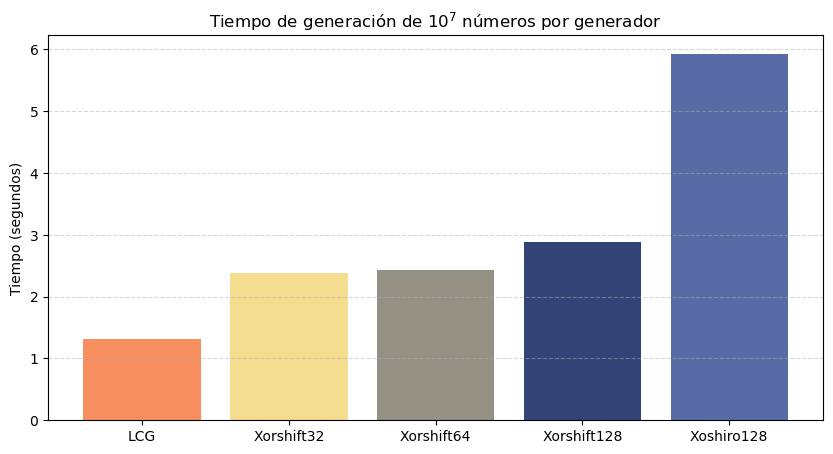

In [33]:
import matplotlib.pyplot as plt

res = test_tiempo_generacion()

nombres, tiempos = zip(*res)

plt.figure(figsize=(10, 5))
plt.bar(nombres, tiempos, color=[gen.color for gen in generadores])
plt.ylabel("Tiempo (segundos)")
plt.title("Tiempo de generación de $10^7$ números por generador")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## Test de Repetibilidad

In [34]:
def test_repetibilidad(N=1_000_000):
    """
    Prueba la repetibilidad de todos los generadores.
    """
    res = {}
    for gen in generadores:
        rng = gen.funcion

        resetear_estados_originales()
        secuencia1 = [rng() for _ in range(N)]

        resetear_estados_originales()
        secuencia2 = [rng() for _ in range(N)]

        es_repetible = secuencia1 == secuencia2
        res[gen.nombre] = es_repetible
        print(f"{gen.nombre}: {'✅ Repetible' if es_repetible else '❌ No repetible'}")

test_repetibilidad()

LCG: ✅ Repetible
Xorshift32: ✅ Repetible
Xorshift64: ✅ Repetible
Xorshift128: ✅ Repetible
Xoshiro128: ✅ Repetible


## Evaluación Visual de Independencia y Uniformidad

### Distribución Individual

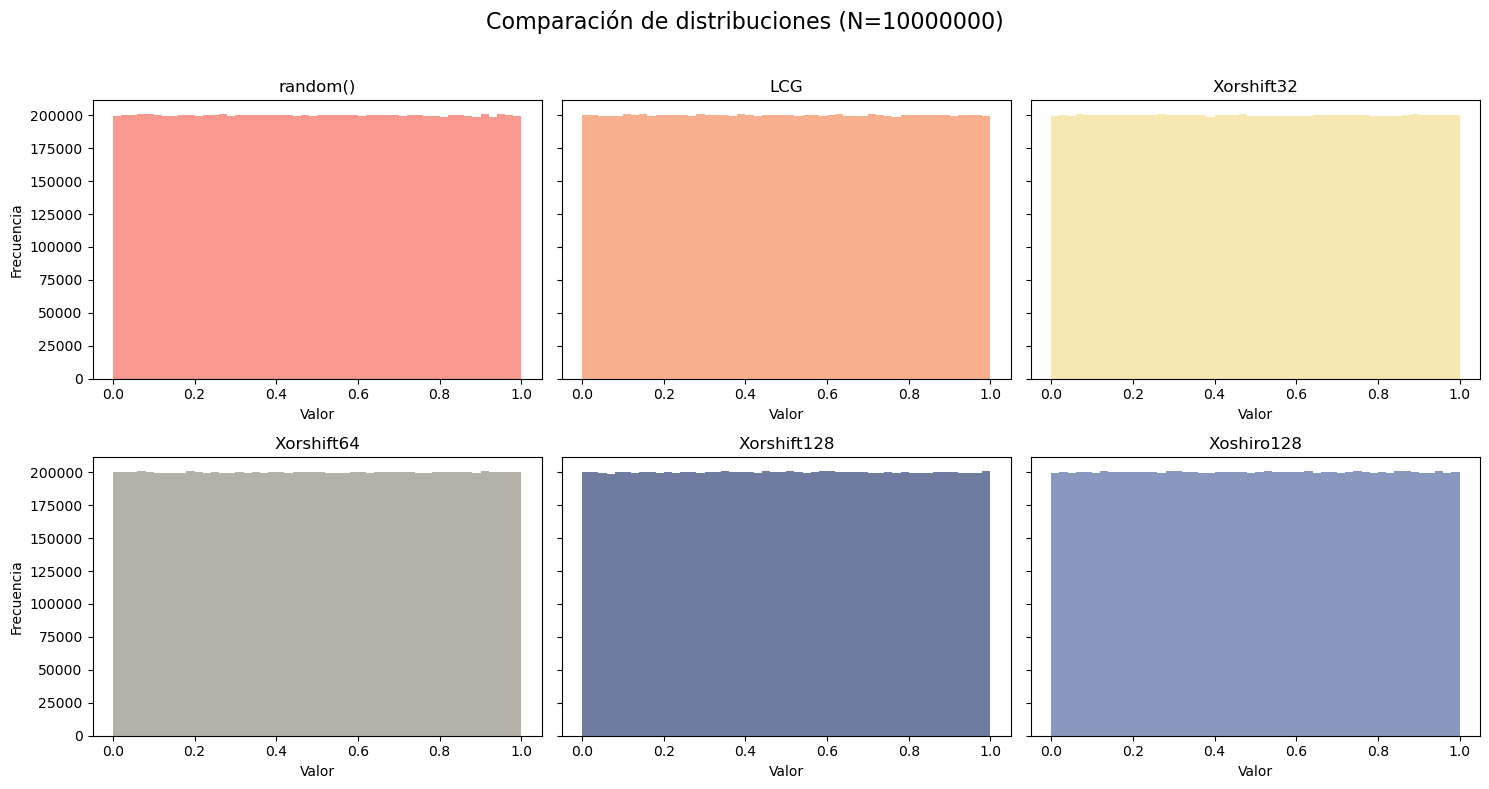

In [35]:
from random import random, seed
seed(42)

def generar_muestras(generador, N):
    """
    Genera N muestras con el generador dado.
    """
    return [generador.generar_normalizado() for _ in range(N)]

def graficar_histogramas(generadores, N):
    """
    Genera histogramas para una lista de generadores.
    """
    num_generadores = len(generadores) + 1
    ncols = 3
    nrows = (num_generadores + ncols - 1) // ncols

    _, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
    axes = axes.flatten()

    # Histograma de random()
    muestras_random = [random() for _ in range(N)]
    axes[0].hist(muestras_random, bins=50, color='#F76C5E', alpha=0.7)
    axes[0].set_title('random()')
    axes[0].set_xlabel('Valor')
    axes[0].set_ylabel('Frecuencia')

    # Demás Histogramas
    for i, gen in enumerate(generadores, start=1):
        muestras = generar_muestras(gen, N)
        axes[i].hist(muestras, bins=50, color=gen.color, alpha=0.7)
        axes[i].set_title(gen.nombre)
        axes[i].set_xlabel('Valor')
        if i % ncols == 0:
            axes[i].set_ylabel('Frecuencia')

    plt.suptitle(f'Comparación de distribuciones (N={N})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

graficar_histogramas(generadores, 10_000_000)


### Distribución de a Pares

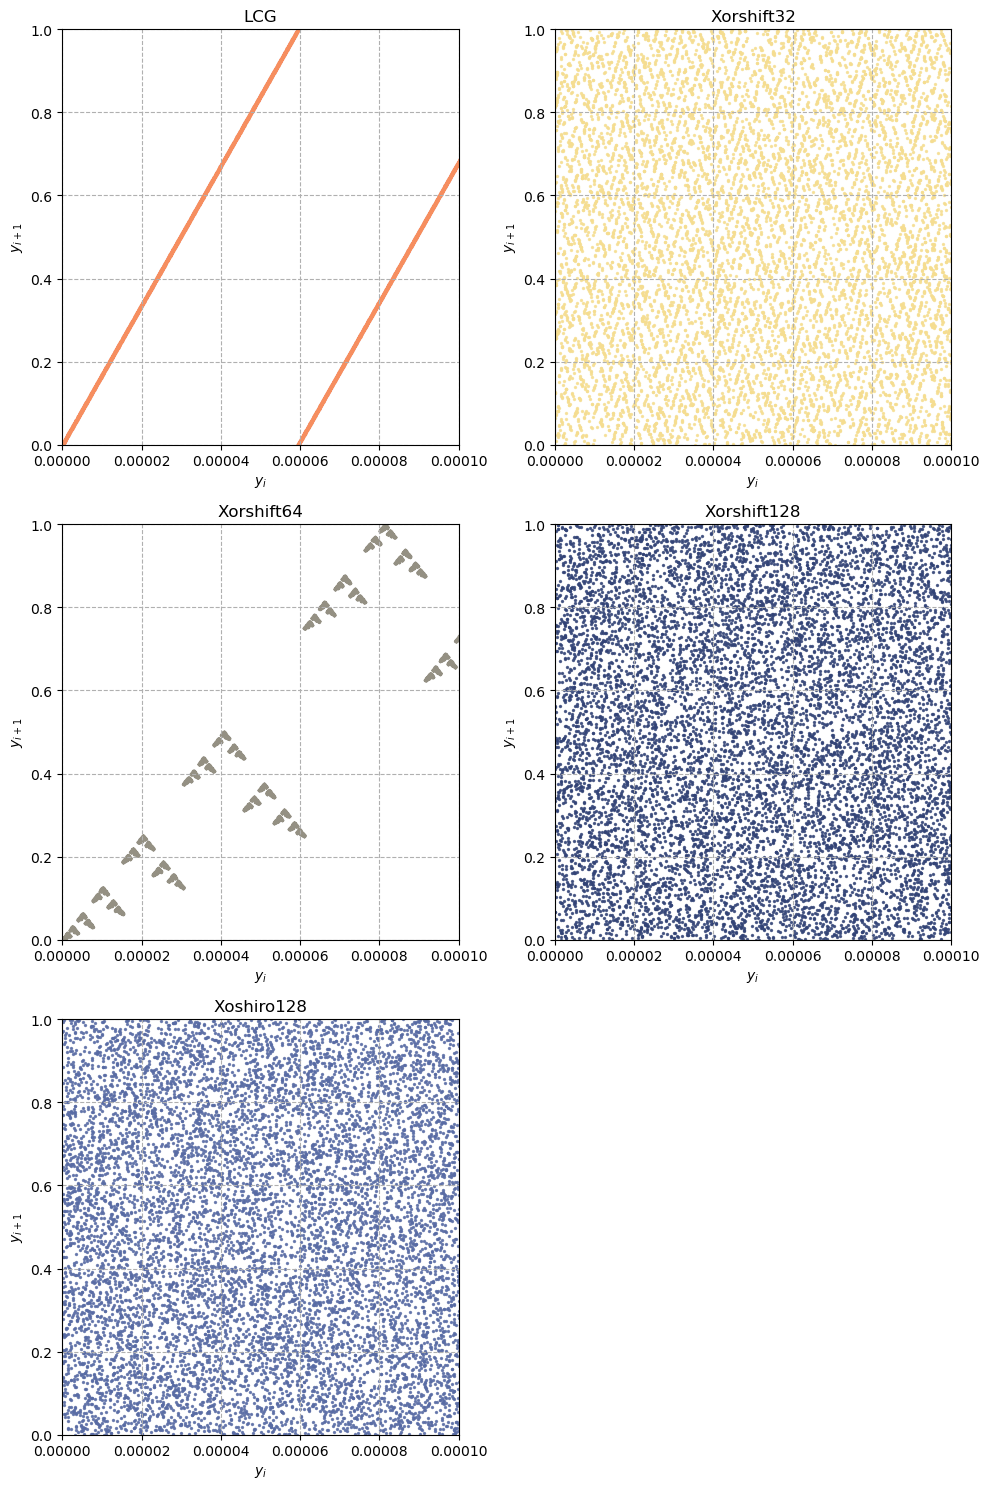

In [37]:
num_gen = len(generadores)
cols = 2
rows = (num_gen + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, gen in enumerate(generadores):
    y = np.array([gen.generar_normalizado() for _ in range(100_000_000 + 1)])
    x_vals, y_vals = y[:-1], y[1:]

    ax = axes[i]
    ax.scatter(x_vals, y_vals, s=2.0, color=gen.color, alpha=0.8)
    ax.set_title(f"{gen.nombre}", fontsize=12)
    ax.set_xlabel(r"$y_i$")
    ax.set_ylabel(r"$y_{i+1}$")
    ax.grid(True, linestyle="--", alpha=1.0)
    ax.set_xlim(0.0, 0.0001)
    ax.set_ylim(0.0, 1.0)

# Si hay subplots vacíos, ocultarlos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Distribución Cubo Unitario

In [38]:
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D  # por compatibilidad
from IPython.display import display, clear_output

def sample_triplets(rng_func, n_triplets):
    """
    Genera una colección de n_triplets puntos en 3D utilizando un generador de números aleatorios normalizado entre 0 y 1.
    """
    xs, ys, zs = [], [], []
    for _ in range(n_triplets):
        xs.append(rng_func())
        ys.append(rng_func())
        zs.append(rng_func())
    return np.array(xs), np.array(ys), np.array(zs)

def plot_3d(xs, ys, zs, elev=30, azim=45, title="", color="b", zoom=1.0):
    """
    Dibuja un gráfico de dispersión 3D con los puntos provistos.
    """
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=5, c=color)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    centro = 0.5
    rango = 0.5 / zoom  # cuanto mayor zoom, menor rango visible
    ax.set_xlim(centro - rango, centro + rango)
    ax.set_ylim(centro - rango, centro + rango)
    ax.set_zlim(centro - rango, centro + rango)
    
    plt.show()

# Widgets
selector = widgets.Dropdown(
    options=[gen.nombre for gen in generadores],
    description='Generador:'
)

slider_elev = widgets.IntSlider(min=0, max=90, step=5, value=30, description='Elevación')
slider_azim = widgets.IntSlider(min=0, max=360, step=5, value=45, description='Azimut')
slider_puntos = widgets.IntSlider(min=1000, max=100000, step=1000, value=10_000, description='Puntos')
slider_zoom = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Zoom')

out = widgets.Output()

def actualizar_plot(_=None):
    """
    Callback para actualizar el gráfico 3D cada vez que cambia un parámetro interactivo.
    """
    with out:
        clear_output(wait=True)
        nombre = selector.value
        gen = next(g for g in generadores if g.nombre == nombre)
        n_puntos = slider_puntos.value
        xs, ys, zs = sample_triplets(gen.generar_normalizado, n_puntos)
        plot_3d(xs, ys, zs,
                elev=slider_elev.value,
                azim=slider_azim.value,
                title=f'Distribución 3D - {gen.nombre}',
                color=gen.color,
                zoom=slider_zoom.value)


grid_sliders = widgets.GridBox(
    children=[slider_puntos, slider_zoom, slider_elev, slider_azim],
    layout=widgets.Layout(
        grid_template_columns="50% 50%",
        grid_template_rows="auto auto",
        grid_gap="10px 10px"
    )
)

selector.observe(actualizar_plot, names='value')
slider_elev.observe(actualizar_plot, names='value')
slider_azim.observe(actualizar_plot, names='value')
slider_puntos.observe(actualizar_plot, names='value')
slider_zoom.observe(actualizar_plot, names='value')

display(widgets.VBox([
    selector,
    grid_sliders
]), out)

actualizar_plot()


Output()

## Test de Bondad de Ajuste Chi-cuadrado

In [39]:
def test_chi2_simulado(generador, distribuciones, Nsim=125_000, n=800):
    """
    Dado un generador de números pseudoaleatorios en el intervalo (0,1) devuelve una lista de los p-valores obtenidos al
    realizar el test de hipótesis chi-cuadrado de Pearson para las distribuciones:
    • Uniforme Discreta {1, 10}
    • Bernoulli (0.5)
    • Binomial (3, 0.5)
    • Poisson (4)
    • Geom (0.5)
    Para cada test, la hipotésis nula es que la muestra de tamaño n simulada a partir del generador, proviene de la
    distribución en cuestión.
    """
    rng = generador.generar_normalizado
    p_valores = []

    def obtener_frecuencias_observadas(k, probs):
        f_o = [0] * k
        N_restante = n
        p_acum = 0
        for i in range(k - 1):
            pi = probs[i] / (1 - p_acum)
            N = binomial(N_restante, pi, random) # Usamos random para generar frecuencias observadas
            f_o[i] = N
            N_restante -= N
            p_acum += probs[i]
        f_o[k - 1] = N_restante
        return f_o
    
    for dist in distribuciones:
        if dist.tipo != "discreta": continue 
        muestra = [dist.sample(rng) for _ in range (n)]
        min_x = min(muestra)
        max_x = max(muestra)
        k = min(max_x, 100) - min_x + 1
        probs = [0] * k
        for i in range (k-1):
            probs[i] = dist.p(i + min_x)
        probs[k-1] =  1 - sum(probs)     # Acumulamos en el ultimo bin cuando K >= 100000
        frecuencias_observadas = [muestra.count(i) for i in range(k)]
        frecuencias_esperadas = [n*probs[i] for i in range (k)]
        t = sum((frecuencias_observadas[i] - frecuencias_esperadas[i])**2 / frecuencias_esperadas[i] for i in range(k))
        p_valor = 0
        for _ in range(Nsim):
            frecuencias_observadas = obtener_frecuencias_observadas(k, probs)
            t_i = sum((frecuencias_observadas[i] - frecuencias_esperadas[i])**2 / frecuencias_esperadas[i] for i in range(k))
            if t_i >= t:
                p_valor += 1
        p_valores.append((dist.nombre, p_valor/Nsim))

    return p_valores


In [ ]:
import matplotlib.gridspec as gridspec

def graficar_pvalores(distribuciones, test):
    res = {}
    for gen in generadores:
        res[gen.nombre] = test(gen, distribuciones)

    N = len(distribuciones)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # cerrar el círculo

    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    for i, gen in enumerate(generadores):
        r = res[gen.nombre]
        row, col = divmod(i, 2)
        if i == 4:
            ax = fig.add_subplot(gs[2, :], polar=True)  # último gráfico ocupa toda la tercera fila
        else:
            ax = fig.add_subplot(gs[row, col], polar=True)

        valores = [p for (_, p) in r]
        valores += valores[:1]

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_ylim(0, 1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([distribuciones[j].nombre for j in range(N)])
        ax.set_yticklabels([])

        ax.plot(angles, valores, color=gen.color, linewidth=2)
        ax.fill(angles, valores, color=gen.color, alpha=0.25)
        ax.set_title(gen.nombre, y=1.1)

    plt.tight_layout()
    plt.show()


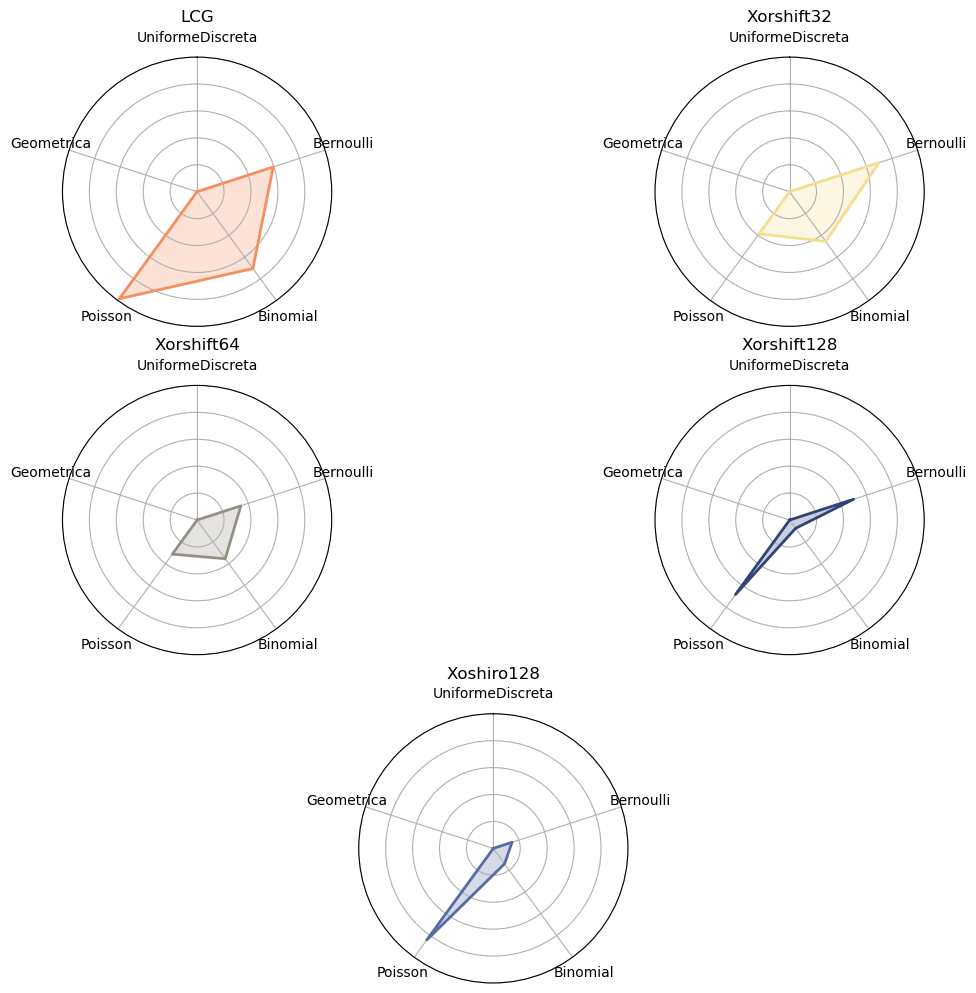

In [41]:
distribuciones = [
    Distribucion(nombre="UniformeDiscreta", parametros=(1, 10), tipo="discreta", generar_valor=uniforme_discreta, funcion_probabilidades=pmf_uniforme_discreta),
    Distribucion( nombre="Bernoulli", parametros=(0.5,), tipo="discreta", generar_valor=bernoulli, funcion_probabilidades=pmf_bernoulli),
    Distribucion( nombre="Binomial", parametros=(3, 0.5), tipo="discreta", generar_valor=binomial, funcion_probabilidades=pmf_binomial),
    Distribucion( nombre="Poisson", parametros=(4.0,), tipo="discreta", generar_valor=poisson, funcion_probabilidades=pmf_poisson),
    Distribucion( nombre="Geometrica", parametros=(0.5,), tipo="discreta", generar_valor=geometrica, funcion_probabilidades=pmf_geometrica)
]

graficar_pvalores(distribuciones, test_chi2_simulado)

## Test de Bondad de Ajuste Kolmogorov-Smirnov

In [ ]:
def test_KS_simulado(generador, distribuciones, Nsim=100, n=1_000_000):
    """
    Dado un generador de números pseudoaleatorios en el intervalo (0,1) devuelve una lista de los p-valores obtenidos al
    realizar el test de hipótesis Kolmogorov-Smirnov para las distribuciones:
    • Uniforme (1,10)
    • Normal (0,1)
    • Exponencial (4)
    • Gamma (4,2)
    • Weibull (4,2)
    Para cada test, la hipotésis nula es que la muestra de tamaño n simulada a partir del generador, proviene de la
    distribución en cuestión.
    """
    rng = generador.generar_normalizado
    p_valores = []

    def calcular_estadistico():
        d_KS = 0
        uniformes = np.random.uniform(0,1,n)
        uniformes.sort()
        for j in range(n):
            u = uniformes[j]
            d_KS = max(d_KS, (j+1)/n - u, u - j/n)
        return d_KS
    
    for dist in distribuciones:
        muestra = [dist.sample(rng) for _ in range (n)]
        muestra.sort()
        d = 0
        for j in range(n):
            yj = dist.p(muestra[j])
            d = max(d, (j+1)/n - yj, yj - j/n)
        p_valor = 0
        for _ in range(Nsim):
            d_j = calcular_estadistico()
            if d_j >= d:
                p_valor += 1
        p_valores.append((dist.nombre, p_valor/Nsim))


    return p_valores


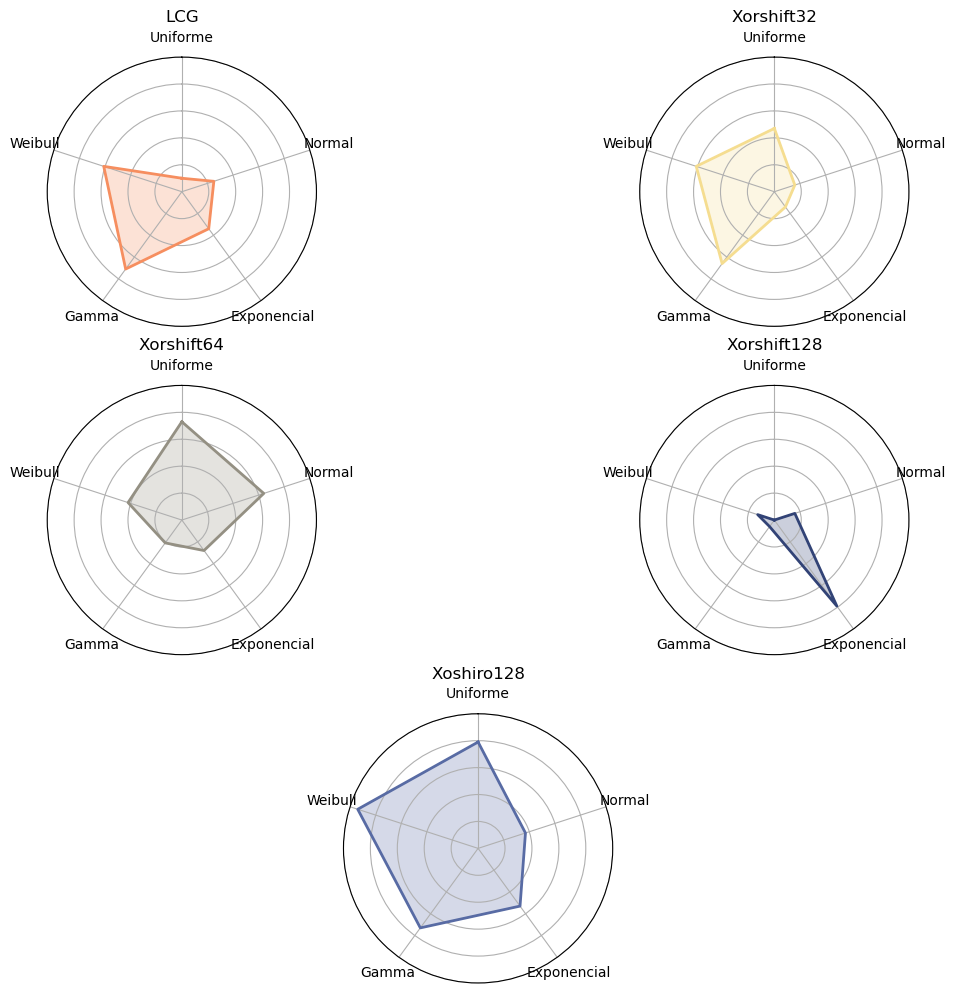

In [44]:
distribuciones = [
    Distribucion(nombre="Uniforme", parametros=(1, 10), tipo="continua", generar_valor=uniforme, funcion_probabilidades=cdf_uniforme),
    Distribucion(nombre="Normal", parametros=(0, 1), tipo="continua", generar_valor=normal, funcion_probabilidades=cdf_normal),
    Distribucion(nombre="Exponencial", parametros=(4,), tipo="continua", generar_valor=exponencial, funcion_probabilidades=cdf_exponencial),
    Distribucion(nombre="Gamma", parametros=(4, 2), tipo="continua", generar_valor=gamma, funcion_probabilidades=cdf_gamma),
    Distribucion(nombre="Weibull", parametros=(4, 2), tipo="continua", generar_valor=weibull, funcion_probabilidades=cdf_weibull)
]

graficar_pvalores(distribuciones, test_KS_simulado)

# Gráficas

## Costo (ECM × Tiempo)

In [48]:
def graficar_costos(estimaciones=1000):
    resultados_por_generador = {g.nombre: [] for g in generadores}

    for _ in range(estimaciones):
        for g in generadores:
            res = simular(g.generar_normalizado, 10, 1_000_000)
            resultado = ResultadoSimulacion(
                generador=g.nombre,
                dimension=10,
                N=1_000_000,
                estimacion=res[0],
                tiempo=res[1],
                error_abs=abs(res[0] - valores_reales[10]),
                varianza=res[2],
                ecm=res[3]
            )
            resultados_por_generador[g.nombre].append(resultado)

    tiempos = []
    ecms = []
    costos = []
    generadores_nombres = []
    for nombre, res_list in resultados_por_generador.items():
        tiempos.append(np.mean([r.tiempo for r in res_list]))
        ecms.append(np.mean([r.ecm for r in res_list]))
        costos.append(np.mean([r.tiempo * r.ecm for r in res_list]))
        generadores_nombres.append(nombre)

    color_por_generador = {g.nombre: g.color for g in generadores}
    colores = [color_por_generador.get(nombre, 'gray') for nombre in generadores_nombres]

    # Normalizar tamaños para visibilidad
    costos_np = np.array(costos)
    if costos_np.size > 0:
        tamaños = 1000 * (costos_np / costos_np.max())
    else:
        tamaños = []

    plt.figure(figsize=(8, 6))
    plt.scatter(tiempos, ecms, s=tamaños, c=colores, alpha=0.7)

    for j, gen in enumerate(generadores_nombres):
        plt.text(tiempos[j], ecms[j], gen, fontsize=9, ha='right')

    plt.xlabel('Tiempo (s)')
    plt.ylabel('ECM')
    plt.title(f'Tiempo vs ECM (tamaño ∝ ECM × tiempo)\nPromedios de {estimaciones} simulaciones — N = 1,000,000, d=10')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


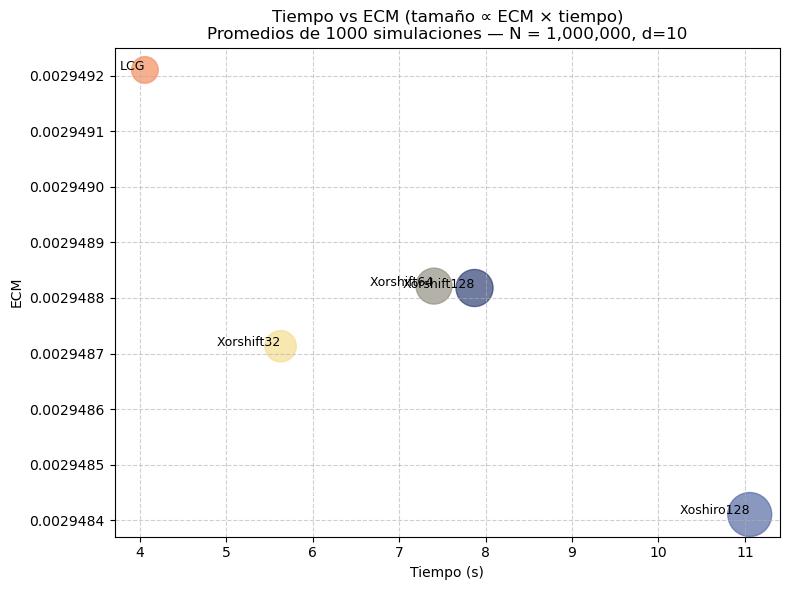

In [49]:
graficar_costos()